# Differentially Private Data Science - What, Why And How?

Differential privacy has become a standard framework for applying strict individual privacy protection. It provides a controlled way to ingest calibrated noise into sensitive datasets so that any statistical analyses conducted on them are in line with current legal demands like GDPR or CCPA. The core idea behind DP is that the addition or removal of any individual from a sensitive dataset should not significantly affect the result of an analysis. This feature provides a strong privacy guarantee, allowing analysts and scientists to prevent linkage attacks, which is crucial in many domains such as research, medicine, census and finance. In this tutorial, we will explore how this mathematical framework works, how to implement it and important related ideas. 

## Why Do We Need Differential Privacy?

Differential privacy uses randomized computations to preserve individual privacy. This means that every time you calculate a differentially private statistic (like the mean) of a dataset, you get a different result each time that is close to the _true value of the statistic_. 

To make each result truly irreversible, DP introduces a calibrated noise drawn from a probability distribution, typically the Laplace distribution. The drawn noise should be large enough to mask the presence or absence of any single individual in the dataset, but small enough to maintain the utility of the data for analysis purposes.

There are several scenarios where such precaution is necessary.

For example, in a medical study about a rare disease, if an attacker knows the total count and can find out that it increased by one after a specific person joined the study, they could infer that person's medical condition. Or in a salary database, if an attacker knows the mean salary before and after a new employee joins, they could potentially calculate that individual's exact salary. Another example is in voting data: if the mean age of voters in a small district is known, and then changes slightly after one person votes, their age and voting status could be deduced.

Therefore, DP adds random noise to computations on sensitive data to ensure similar results when comparing datasets that differ by one record.

![](https://www.anonos.com/hs-fs/hubfs/differential/Diff.1.webp?width=834&height=429&name=Diff.1.webp)

[Source: Anonos](https://www.anonos.com/blog/what-is-differential-privacy-definition-mechanisms-examples#toc-1)

## Sensitivity And Epsilon in Differential Privacy

In the last section, we mentioned that DP injects noise drawn from probability distributions into datasets. The amount of noise should be carefully calibrated to maintain the usability of data. For example, if a _true count_ of samples in a dataset is 1000, the private count cannot be too far, like 1500, because it would make the statistic useless. So, to control the amount of this noise, DP uses two components: __sensitivity of a function__ and __epsilon hyperparameter__. 

Function sensitivity is the maximum amount the function output can change if a single unit is added or removed from the input dataset. For example, the sensitivity of a counter function is 1 because removing a single row from a dataset changes the counter's output by only 1. This concept is critical in DP because sensitivity determines how much noise should be added to a dataset. The larger the sensitivity, the more noise must be added.

But sensitivity alone isn't enough because we need _epsilon_ to control the privacy-utility tradeoff. If we only use sensitivity to add noise, we would always add the same fixed amount of noise regardless of privacy needs.

However, different scenarios require different privacy needs. For a low-stakes nation-wide public survey, we might be okay with less privacy, adding minimal noise. For sensitive medical data, we need stronger privacy, requiring more noise. 

DP combines sensitivity and epsilon in such a way that lower epsilon increases the noise while higher epsilon lowers it. For example, with epsilon=1, a counter function might add noise ±2-3 to the true count. But with epsilon=0.1 (stronger privacy), it might add noise ±20-30. Epsilon gives us this crucial flexibility to tune privacy protection based on context.

## Implementing Epsilon Differential Privacy

Now, let's make the theory concrete by implementing DP versions of a counter and average functions:

In [1]:
import numpy as np


def true_counter(data):
    return len(data)

def true_mean(data):
    return np.mean(data)

First, we define two functions to find the true length and mean of a dataset. Now, let's implement `private_counter` that uses the Laplace mechanism (injects noise drawn from the Laplace distribution):

In [2]:
def private_counter(data, epsilon):
    sensitivity = 1
    scale = sensitivity / epsilon
    
    noise = np.random.laplace(0, scale)
    private_count = int(true_counter(data) + noise)
    return private_count

The `laplace` function of the `np.random` module requires a `scale` parameter which sets an anchor in the distribution around which the noise is drawn. We calculate the correct scale based on our needs by dividing sensitivity by epsilon. After the noise is drawn, we add the noise to the true count. Let's test it with different values of epsilon on a synthetic dataset with 1000 points:

In [3]:
# Test private_counter on a synthetic dataset with 1000 points
data = np.ones(1000)

epsilons = [0.1, 1.0, 10.0]
for epsilon in epsilons:
    private_count = private_counter(data, epsilon)
    
    print(f"Epsilon: {epsilon}")
    print(f"True count: {true_counter(data)}")
    print(f"Private count: {private_count}\n")

Epsilon: 0.1
True count: 1000
Private count: 997

Epsilon: 1.0
True count: 1000
Private count: 998

Epsilon: 10.0
True count: 1000
Private count: 999



As we can see from the output, with a smaller epsilon value (0.1), we get more noise added to the true count, resulting in a larger difference between the true and private counts. As epsilon increases (1.0 and 10.0), the noise decreases and the private count gets closer to the true count of 1000. 

Now, let's implement `private_mean` function:

In [7]:
def private_mean(data, epsilon):
    # For mean, sensitivity is 1/n since changing one element
    # affects mean by at most 1/n where n is dataset size
    n = len(data)
    sensitivity = 1.0 / n
    scale = sensitivity / epsilon
    
    noise = np.random.laplace(0, scale)
    result = true_mean(data) + noise
    return result

patient_ages = [25, 30, 35, 40, 45, 50, 55, 60]

# Test with different epsilon values
epsilons = [0.01, 0.1, 1]
for epsilon in epsilons:
    priv_mean = private_mean(patient_ages, epsilon)
    print(f"Epsilon: {epsilon}")
    print(f"True mean: {true_mean(patient_ages)}")
    print(f"Private mean: {priv_mean}\n")

Epsilon: 0.01
True mean: 42.5
Private mean: 51.35476355418572

Epsilon: 0.1
True mean: 42.5
Private mean: 42.88750141072553

Epsilon: 1
True mean: 42.5
Private mean: 42.507711105508164



Similar to the counter example, we can observe that with a smaller epsilon value (0.011), more noise is added to the true mean, resulting in a larger difference between the true and private means. As epsilon increases (0.01 and 1), the noise decreases and the private mean gets closer to the true mean of the patient ages. This demonstrates the privacy-utility tradeoff in differential privacy - lower epsilon provides stronger privacy but less accurate results, while higher epsilon provides more accurate results but weaker privacy guarantees.

## The Importance of Epsilon Shown Visually

In the spring of 2024, I attended an event at Oxford University (hosted by Oblivious AI) dedicated to differential privacy research and I got to work on an interesting problem: creating differentially private data visualizations.

The idea was simple: create a DP version of all plots in Matplotlib so that when displayed, an attacker cannot trace the data points back to the individuals in the dataset. This problem would then serve a double purpose of showing the visual effect of the epsilon parameter. 

Since Matplotlib offers dozens of plotting functions, it wasn't feasible for me and teammate, Devyani Guri {Link her profile}, to recreate DP versions for all plots in a single week. Instead, we came up with a hack - differentially private histogram binning. With this method, we could recreate a DP version of any distribution and then, keep using regular Matplotlib functions to plot them. 

For example, consider this histogram of an original distribution X:

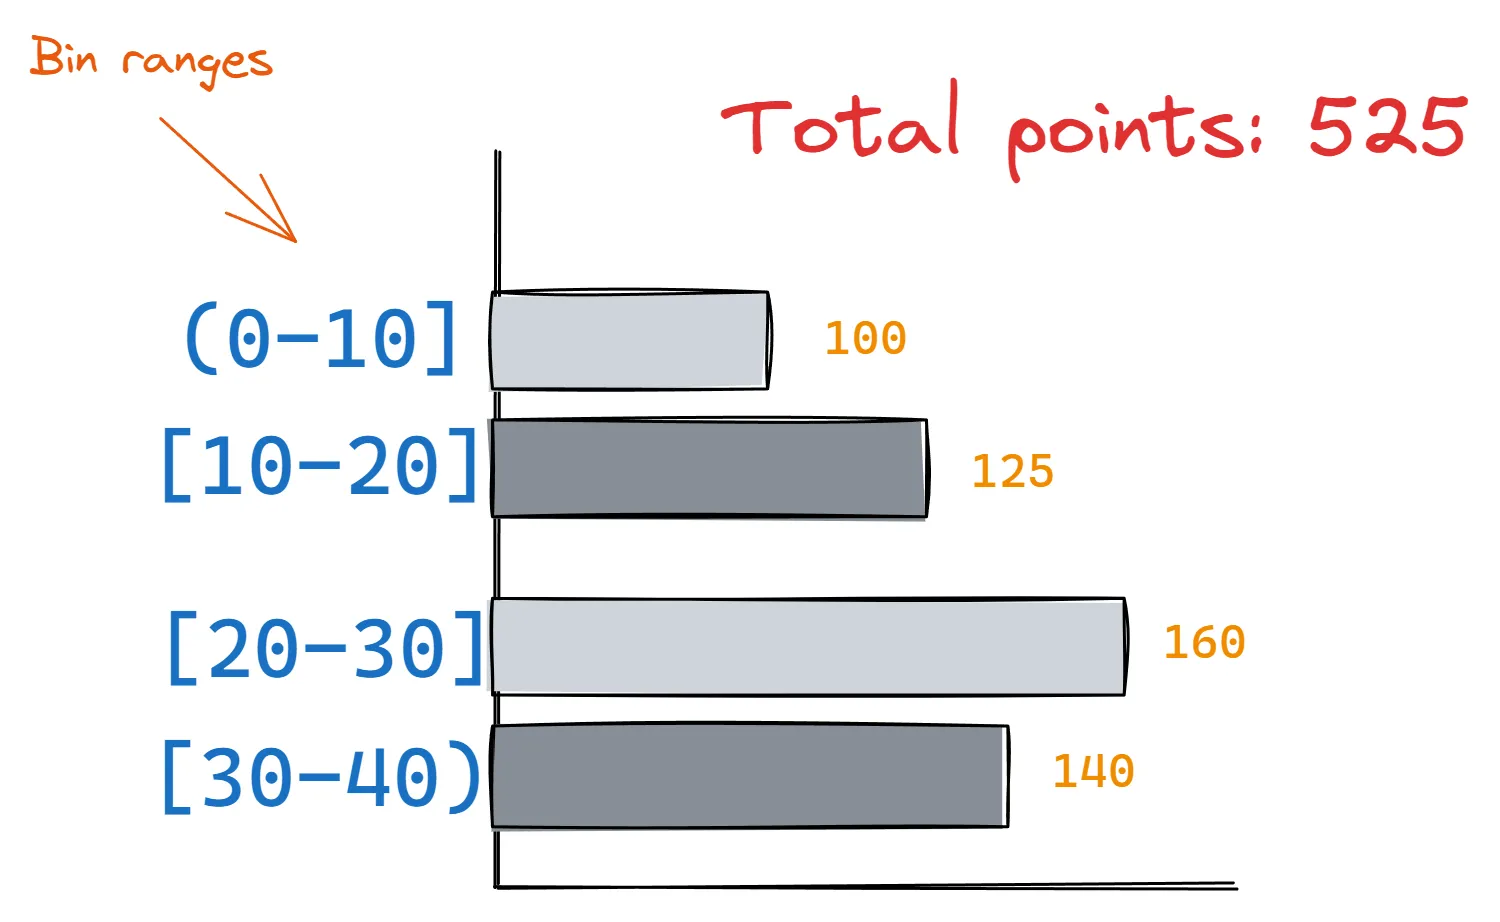

To create a DP version of this histogram, all we would need to do is add Laplace noise to each bin count (we already saw how to do that). Then we can reconstruct the distribution by sampling random data points in each bin range based on the noisy bin counts. 

The reconstructed distribution would be differentially private but its histogram would have a close shape to the original's based on our epsilon usage.

This technique was wildly successful and you can see the result for yourself:

![](diamond_prices_dp.png)

We made a few more tweaks to our approach but the end result is the same: as we lower the epsilon, the private distribution's histogram grows farther and farther apart from the original. 

But how about other plots? During the event, we worked on Kernel Density Estimate plots, box plots and scatterplots as well. You can read about this technique in more detail in [my separate article](https://medium.datadriveninvestor.com/how-to-visualize-differentially-private-datasets-in-matplotlib-with-antigranular-c4ca7c0309ae). Here is a sneak peek for scatterplots that use 2D histogram binning:

![](2d_histogram.png)

At epsilon=1, the original scatterplot's general direction is still visible even though we have noise all over the plot. But when we get to epsilon=0.01, the distribution is completely broken down and scattered all across the canvas. 

To play around with the code that generated these plots, you can check out the example notebook {add the link to notebook} I've prepared.

## Privacy Budget in Differential Privacy

Another fundamental concept in differential privacy is a __privacy budget__ which helps manage the cumulative privacy loss when making multiple queries on a sensitive dataset. Think of it like a bank account of privacy - each query, like finding the mean, plotting a histogram, "spends" some of your privacy budget where the currency is epsilon. 

For example:
- Query 1 with epsilon = 0.1
- Query 2 with epsilon = 0.3
- Total privacy loss = 0.4

If your total privacy budget is 1, you need to carefully plan how to "spend" it and divide it up between all computations you will perform. 

Privacy budget is crucial for a variety of reasons. First, it prevents multiple query attacks, where a malicious party could make many queries with small epsilons and combine the results to reconstruct sensitive data. In the scatterplot example, a few dozen can be created with low epsilons and stacked on top (overlap) to come very close to the original scatter plot of the data. 

Teams must decide whether to:
- Make fewer queries with higher accuracy (larger ε per query)
- Make more queries with lower accuracy (smaller ε per query)
- Save budget for future important queries

Some advanced techniques exist to help manage privacy budgets more efficiently. For example, in parallel composition {add wikipedia link}, if queries are made on disjoint subsets of data, their privacy losses don't add up. The histogram binning approach we have outlined uses this exact method. Since each bin range of the histogram is independent of each other, the epsilon doesn't add up for all bins. In other words, the epsilon stays the same whether you reconstruct histogram with 100 bins or 1000. 

Here is a simple class that implements a simple privacy budget class:

In [5]:
class PrivacyBudget:
    def __init__(self, total_budget):
        self.total_budget = total_budget
        self.spent_budget = 0

    def check_and_spend(self, epsilon):
        if self.spent_budget + epsilon > self.total_budget:
            raise ValueError("Not enough privacy budget remaining!")
        self.spent_budget += epsilon
        return True

    def remaining_budget(self):
        return self.total_budget - self.spent_budget


# Example usage
budget_manager = PrivacyBudget(total_budget=1.0)

# Make multiple queries with different epsilons
data = [25, 30, 35, 40, 45, 50, 55, 60]
epsilons = [0.3, 0.4, 0.2, 0.2]

for i, eps in enumerate(epsilons, 1):
    try:
        budget_manager.check_and_spend(eps)
        result = private_mean(data, eps)
        print(f"Query {i} (ε={eps}): {result:.2f}")
        print(f"Remaining budget: {budget_manager.remaining_budget():.2f}\n")
    except ValueError as e:
        print(f"Query {i} failed: {e}")

Query 1 (ε=0.3): 46.57
Remaining budget: 0.70

Query 2 (ε=0.4): 39.19
Remaining budget: 0.30

Query 3 (ε=0.2): 45.37
Remaining budget: 0.10

Query 4 failed: Not enough privacy budget remaining!


To get a better handle of privacy budget management, I've recently discovered some [free games you can play around](https://www.oblivious.com/games) offered by Oblivious AI:

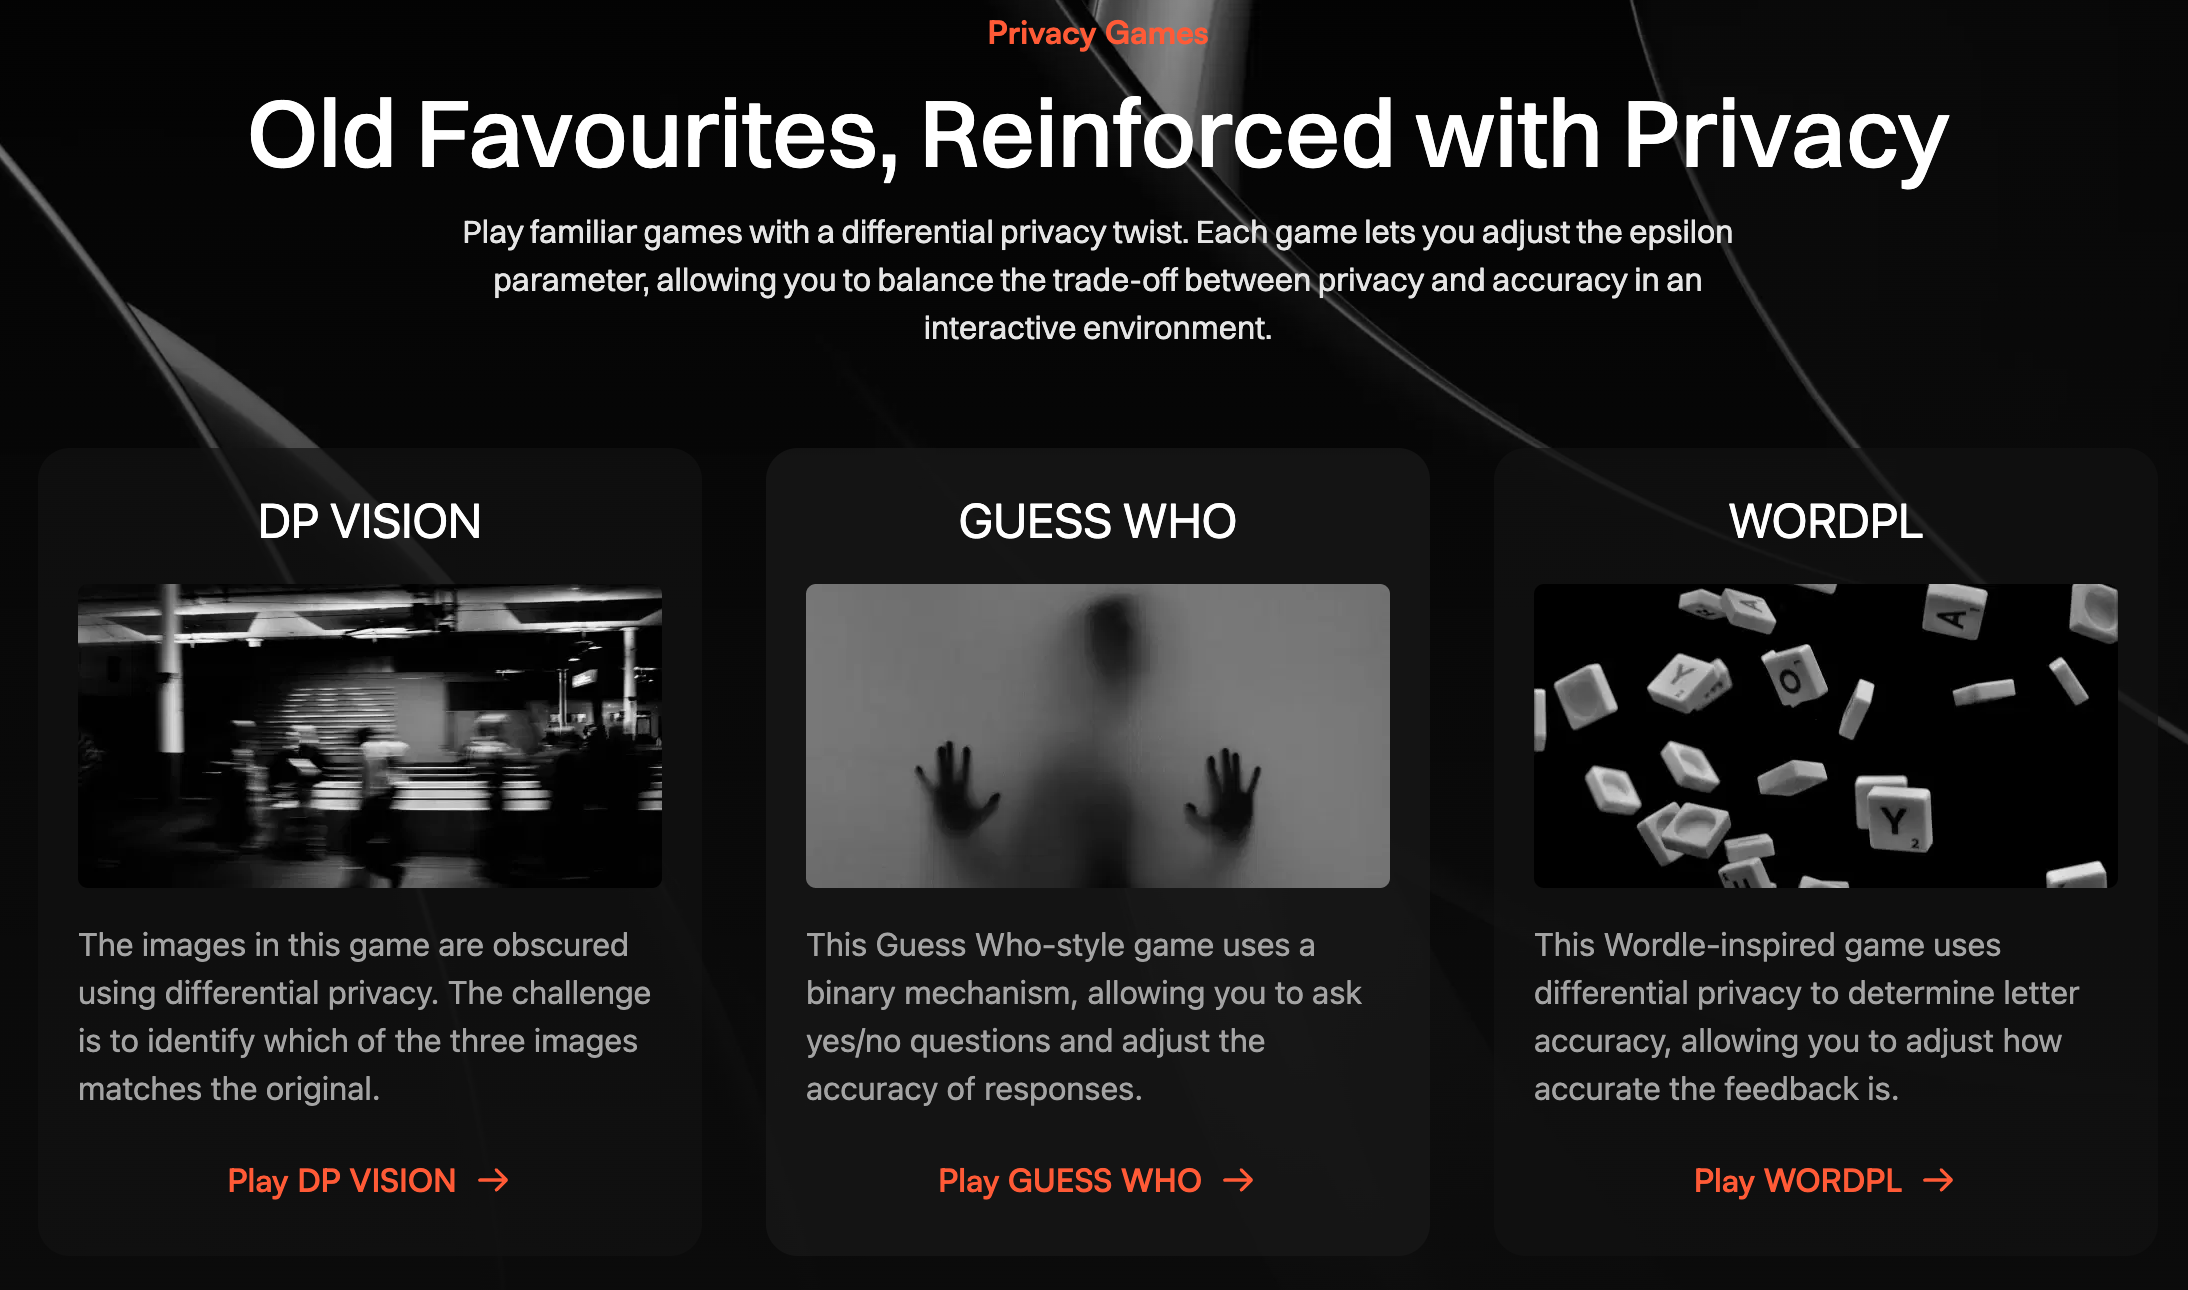

They are DP variants of some classic and popular games like "Guess Who" or "Wordle". I especially like "Guess Who" because it is surprisingly hard to win because of the added uncertainty. 

In this version, you need to guess the person the AI is impersonating by asking binary yes/no questions. But here is the twist: depending on the epsilon you choose, the probability of an honest answer greatly varies. 

For example, if you set epsilon to 1, the probability of a lie is 27%:


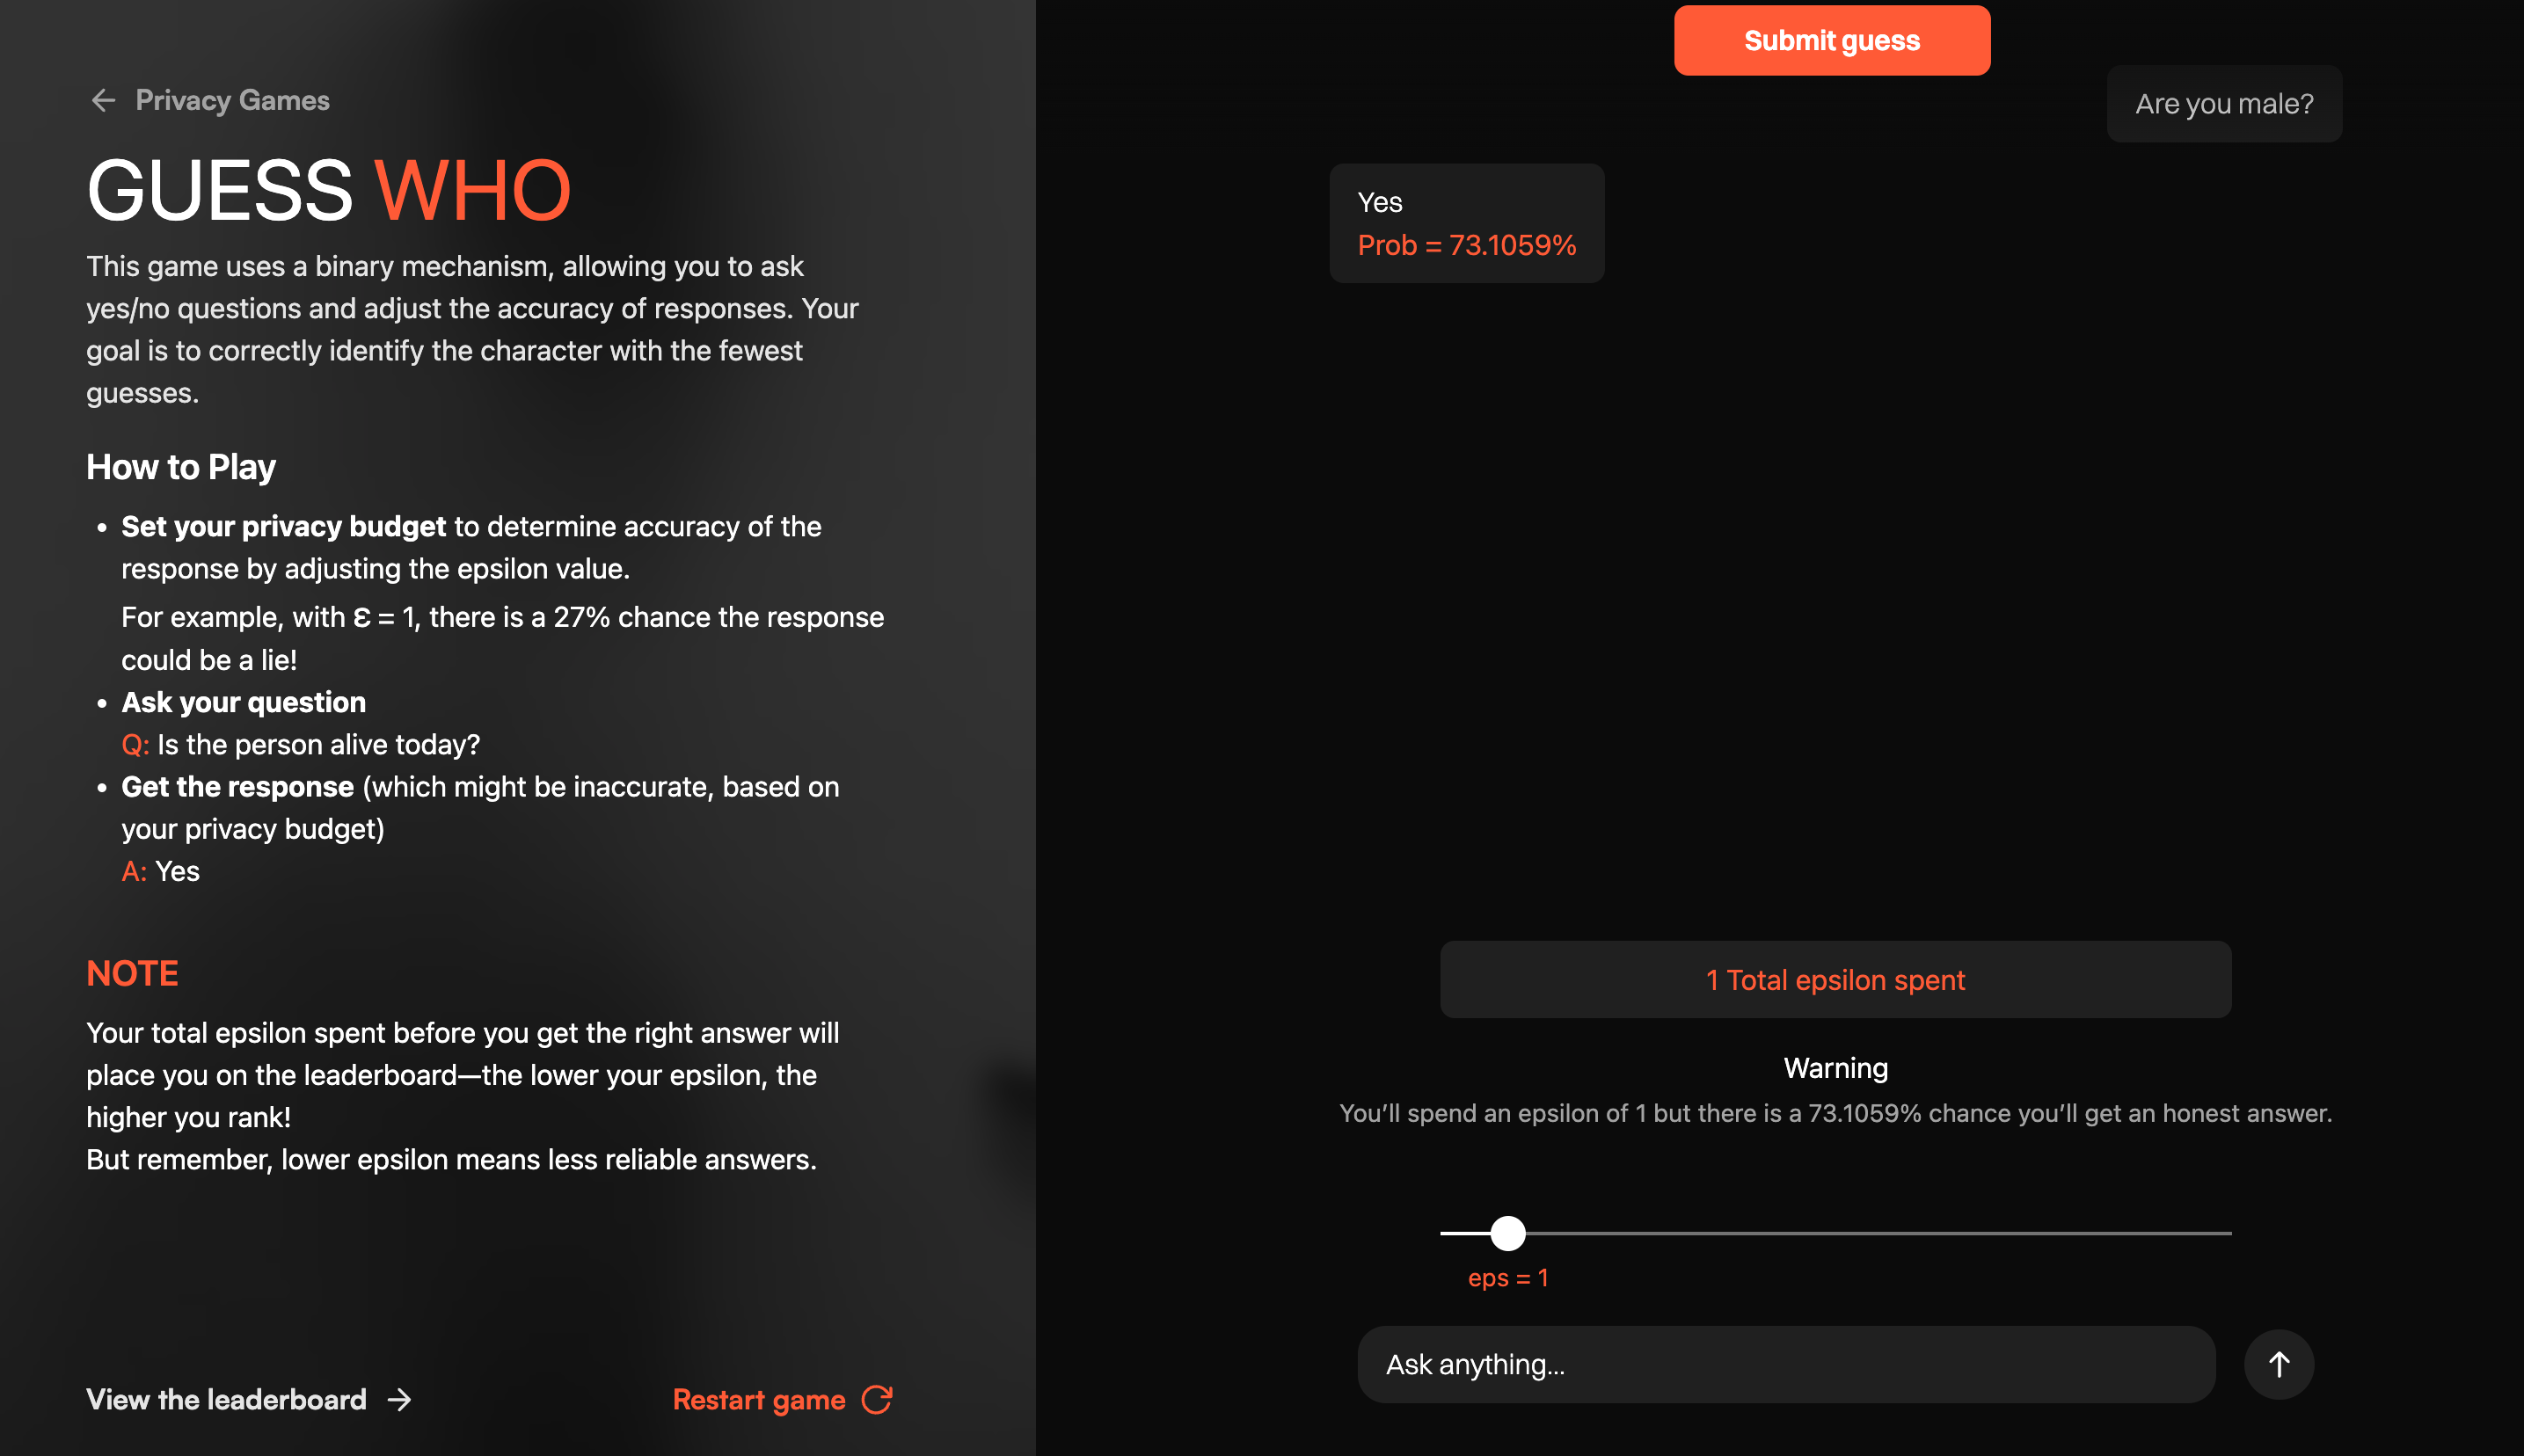

Another twist is that you are competing against other players to take the top spot on the leaderboard. So, you can't just win the game by setting high epsilon (which pretty much guarantees an honest answer every time) but think about the total budget you will use up. 

To give you a rough picture, the person on the first place found the answer in 7 guesses with 8.4 epsilon spent, which amounts to about 75% chance of an honest answer to each question:

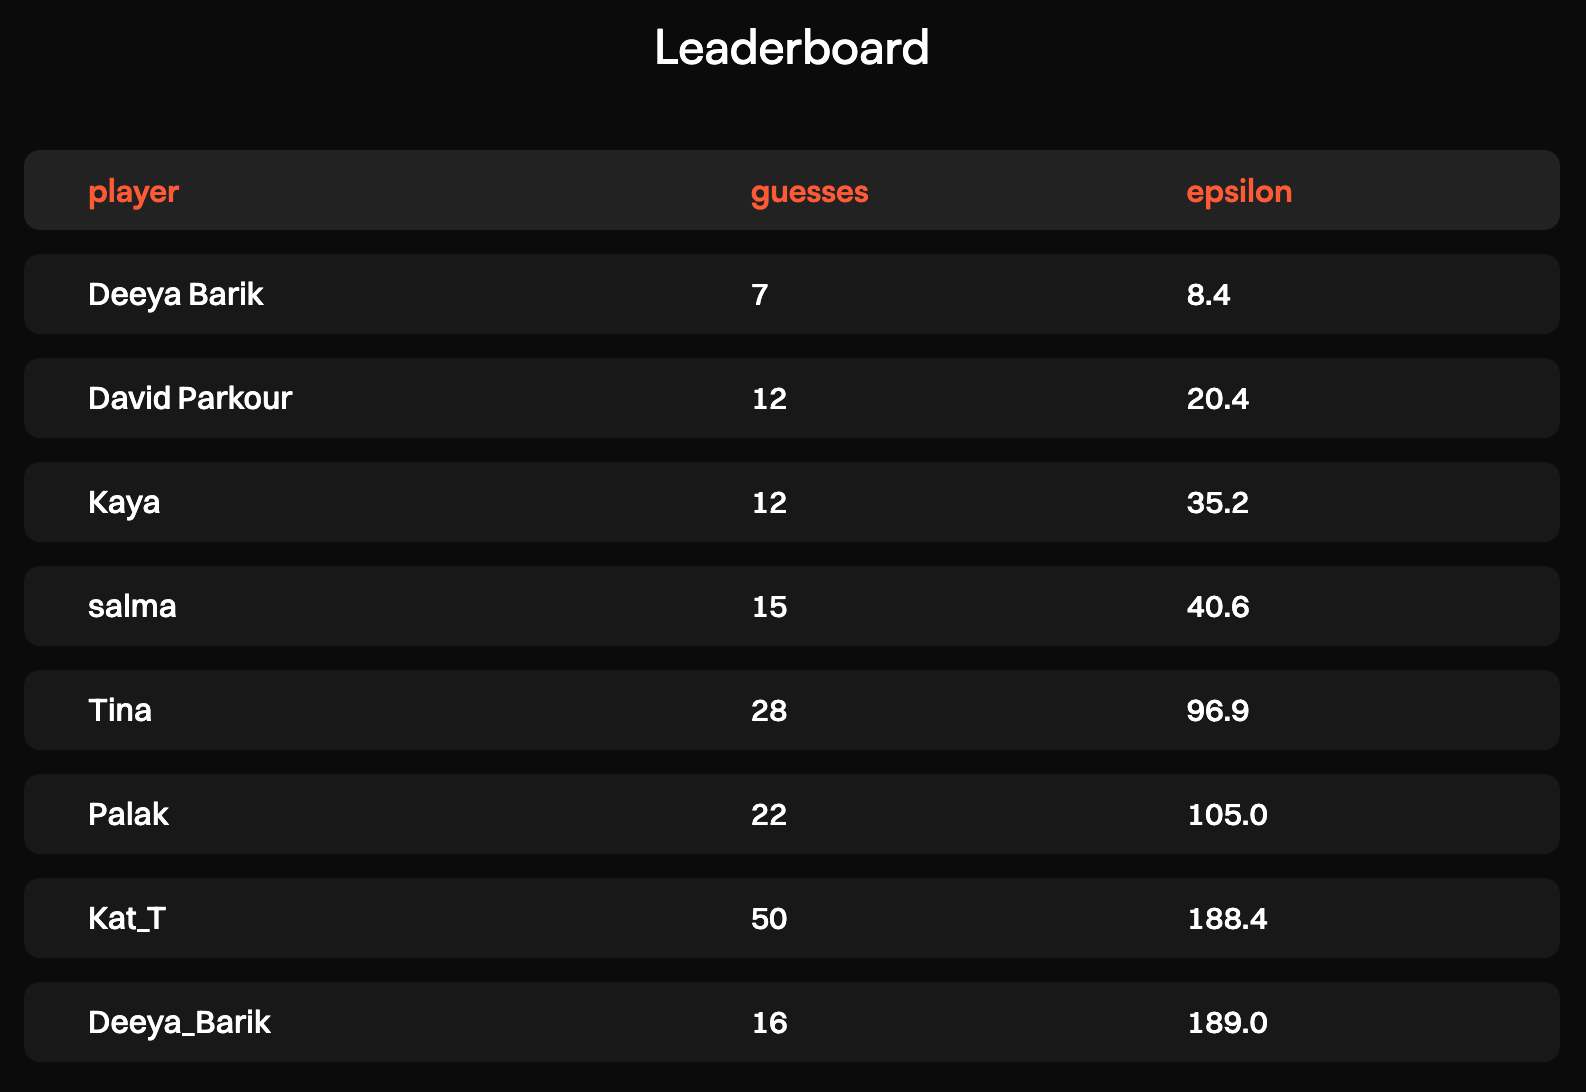

So, try setting your budget to 8 and winning by:
- Asking a lot of questions with low epsilon
- Asking 3-4 key questions with high epsilon

Regardless of the game you play, you will come away with a deeper intuition about managing your privacy budget.

## Conclusion

In this tutorial, we have learned the basics of differential privacy, an important mathematical framework for working with sensitive datasets and preserve individual privacy. We've covered the definition of DP, why it is important and how to implement it in Python for some elementary operations. 

In later sections, we have discussed function sensitivity and epsilon parameters in more detail as they are crucial in your understanding of DP. We've ended things by talking about privacy budgets and how to get a better sense for them by playing online DP games. 

If you want to dive into this novel world of eyes-off data science, you can check out Antigranular as well. It is a Kaggle-like competitions platform where you solve DP problems on real-world sensitive datasets. The challenge is that you have to write code in a dedicated environment where only a handful of DP libraries are available and the datasets aren't visible. I have written about how to [navigate the platform](https://medium.datadriveninvestor.com/how-to-explore-and-clean-sensitive-data-you-cant-even-see-with-antigranular-14efca3cfcae) in a separate article. 

Thank you for reading!